# Imports

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable

# Hydrogen Atom

We will start by studying the Hydrogen Atom:

$$
\begin{align*}

H &= -\frac12\nabla^2 - \frac1r
\\\\


\psi(\textbf r) &= e^{-\beta r}

\end{align*}
$$

# Metropolis Sampling Position

In [13]:
def rvec(pos: np.ndarray) -> float:
    return np.sqrt(pos[0]**2 + pos[1]**2 + pos[2]**2)


def r3(x: float, y: float, z:float) -> float:
    return np.sqrt(x**2 + y**2 + z**2)


def samplePos(M: int, beta: float, delta: float = 0.5) -> np.ndarray:
    """
        Samples M positions taking as the desired distribution psi, assuming psi is real!
    """

    # List of samples
    samples = np.zeros((M), dtype=float)

    # Starting position
    x, y, z = 10, 0.1, 0.01
    rpos = r3(x, y, z)
    samples[0] = rpos

    logpsi = -beta * rpos

    # Metropolis Loop
    succ = 0
    for attempt in range(M-1):
        xp = x + delta*(np.random.random() - 0.5)
        yp = y + delta*(np.random.random() - 0.5)
        zp = z + delta*(np.random.random() - 0.5)

        rposp = r3(xp, yp, zp)
        logpsip = -beta * rposp

        accept = min(1, np.exp(2 * (logpsip - logpsi)))

        # Accept step
        if accept > np.random.random():
            succ += 1

            x, y, z = xp, yp, zp
            rpos = rposp
            logpsi = logpsip
        
        # Save state
        samples[attempt+1] = rpos
    
    print(f"Acceptance: {succ / attempt}")
    return samples

In [14]:
def sampleNeff(data: np.ndarray, k1: int = 0, icutoff: int = 200) -> int:
    # Raw data
    N = len(data)
    k2 = N-1

    # icutoff = int(k2 * icutoff)
    Neq = k2 - k1 + 1

    # Calculate Stats
    ave = np.mean(data)
    var = np.var(data, mean=ave, ddof=1)

    # Calculate autocorrelations and cutoff
    autocorr = np.array([np.sum((data[k1: k2-i]-ave) * (data[k1 + i: k2]-ave)) / (Neq - i) for i in range(1, Neq)]) / (var)
    autocorr = autocorr[:icutoff]

    # Calculate autocorrelation time (sum until we find some negative number)
    timecorr = 1
    for item in autocorr:
        timecorr += 2 * item
        if item < 0:
            break

    Neff = Neq / timecorr
    print(f"Neff: {Neff}")

    return Neff

## No Reweighting

Beta = 0.200
Acceptance: 0.8883184424589945
Neff: 242.86345160121618
Energy = -0.16478955386955113
Variance on Energy = 0.017255997093926254
Standard Deviation on Mean Energy = 0.008429250259864267

Beta = 0.300
Acceptance: 0.8279770636084811
Neff: 527.2661787292126
Energy = -0.27066012393898525
Variance on Energy = 0.0566797680100845
Standard Deviation on Mean Energy = 0.010368097550857134

Beta = 0.400
Acceptance: 0.7789038538471796
Neff: 536.7899769442205
Energy = -0.3121134671477671
Variance on Energy = 0.04143178060212084
Standard Deviation on Mean Energy = 0.008785461909074782

Beta = 0.500
Acceptance: 0.7230297372983064
Neff: 534.6811152384215
Energy = -0.36602207077665216
Variance on Energy = 0.040106116350138866
Standard Deviation on Mean Energy = 0.008660797454031711

Beta = 0.600
Acceptance: 0.6784237898386452
Neff: 1011.7585184179343
Energy = -0.4044792372704043
Variance on Energy = 0.04823096872723838
Standard Deviation on Mean Energy = 0.006904377961760437

Beta = 0.700
A

/tmp/ipykernel_27416/164870256.py:14: RuntimeWarning: invalid value encountered in divide
  autocorr = np.array([np.sum((data[k1: k2-i]-ave) * (data[k1 + i: k2]-ave)) / (Neq - i) for i in range(1, Neq)]) / (var)


Neff: nan
Energy = -0.5
Variance on Energy = 0.0
Standard Deviation on Mean Energy = nan

Beta = 1.100
Acceptance: 0.47079610614748635
Neff: 905.356298364542
Energy = -0.4971860494282001
Variance on Energy = 0.008663851058541998
Standard Deviation on Mean Energy = 0.0030934686933848567

Beta = 1.200
Acceptance: 0.4461261501533538
Neff: 1014.4552691301143
Energy = -0.4816371253783543
Variance on Energy = 0.05170577386433462
Standard Deviation on Mean Energy = 0.007139257889003768

Beta = 1.300
Acceptance: 0.40072009601280173
Neff: 989.1008736886168
Energy = -0.4597324059844267
Variance on Energy = 0.09752522583542594
Standard Deviation on Mean Energy = 0.009929747145018458

Beta = 1.400
Acceptance: 0.3834511268169089
Neff: 637.6809166054394
Energy = -0.4156130904995334
Variance on Energy = 0.2698737478249155
Standard Deviation on Mean Energy = 0.02057209920482318

Beta = 1.500
Acceptance: 0.3529803973863182
Neff: 640.5491630038341
Energy = -0.3790938425777962
Variance on Energy = 0.3763

Text(0.5, 1.0, 'Parameter Sweep')

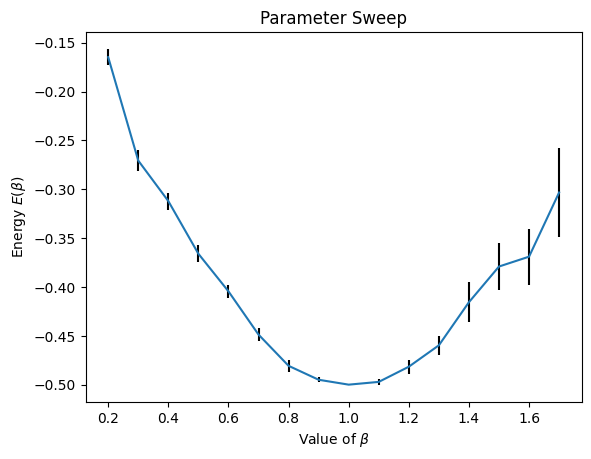

In [15]:
# Parameters
sampleM = 15000
discard = 1500
delta = 2.4

# Sweep Variational Parameter
betaMin = 0.2
betaMax = 1.7

Ebeta = []
Estd = []
Evar = []
bbRange = np.linspace(betaMin, betaMax, 16)
for betaStart in bbRange:
    print(f"Beta = {betaStart:.3f}")
    Rs = samplePos(sampleM, betaStart, delta)
    Rs = Rs[discard:]
    El = -0.5*betaStart*(betaStart - 2/Rs) - 1.0 / Rs

    Neff = sampleNeff(El)

    Evar += [np.var(El)]
    Estd += [np.std(El) / np.sqrt(Neff)]
    Ebeta += [np.average(El)]
    print(f"Energy = {Ebeta[-1]}")
    print(f"Variance on Energy = {Evar[-1]}")
    print(f"Standard Deviation on Mean Energy = {Estd[-1]}")
    print("")

print(f"Best beta: {bbRange[Ebeta.index(np.min(Ebeta))]}")
plt.errorbar(bbRange, Ebeta, yerr=Estd, ecolor="black")
plt.xlabel("Value of $\\beta$")
plt.ylabel("Energy $E(\\beta)$")
plt.title("Parameter Sweep")

# With Reweighting

BetaMid = 2.000
Acceptance: 0.4360726787797966
Neff: 645.6010133962382

BetaMid = 1.400
Acceptance: 0.5705117519586598
Neff: 890.0474132664854

BetaMid = 1.000
Acceptance: 0.6917819636606101
Neff: 212.3810782252111

BetaMid = 1.000
Acceptance: 0.6936989498249708


/tmp/ipykernel_27416/164870256.py:14: RuntimeWarning: invalid value encountered in divide
  autocorr = np.array([np.sum((data[k1: k2-i]-ave) * (data[k1 + i: k2]-ave)) / (Neq - i) for i in range(1, Neq)]) / (var)


Neff: nan

BetaMid = 0.875
Acceptance: 0.7232038673112186
Neff: 526.1706683689359

Final beta: 0.9375
Minimum energy: -0.49427464053076964


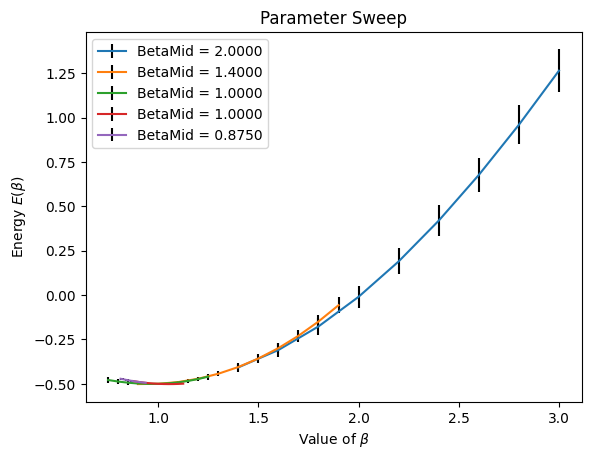

In [16]:
# Sampling Parameters
sampleM = 12000
discard = 2000

delta = 1.4

# Target Function is energy + stdW * std
stdW = 2

# Starting Variational Parameters
betaStart = 2

betaRange = 1
betaSamples = 11
betaMult = 0.5

betaSteps = 5

betaMid = betaStart
for _ in range(betaSteps):
    betaMin = betaMid - betaRange
    betaMax = betaMid + betaRange

    Ebeta = []
    Estd = []
    bb = []
    bbRange = np.linspace(betaMin, betaMax, betaSamples)
    
    print(f"BetaMid = {betaMid:.3f}")
    Rs = samplePos(sampleM, betaMid, delta=delta)
    Rs = Rs[discard:]
    El = -0.5*betaMid*(betaMid - 2/Rs) - 1.0 / Rs
    Neff = sampleNeff(El)
    for beta in bbRange:
        # Calculate weights
        ww = np.exp(-2 * (beta - betaMid) * Rs)

        # Effective number of points
        m = ((np.sum(ww))**2 / np.sum(ww**2)) / len(Rs)
        if m < 0.5:
            continue

        bb += [beta]

        El = -0.5*beta*(beta - 2/Rs) - 1.0 / Rs
        Estd += [np.std(El) / np.sqrt(Neff)]
        Ebeta += [(np.sum(El * ww)) / (np.sum(ww))]
    
    # Plot results
    plt.errorbar(bb, Ebeta, yerr=Estd, ecolor="black", label=f"BetaMid = {betaMid:.4f}")
    
    # Target function
    target = [Ebeta[i] + stdW * Estd[i] for i in range(len(bb))]

    betaMini = bb[target.index(min(target))]
    betaMid = betaMini
    betaRange *= betaMult
    print("")


print(f"Final beta: {betaMini}")
print(f"Minimum energy: {min(Ebeta)}")

plt.xlabel("Value of $\\beta$")
plt.ylabel("Energy $E(\\beta)$")
plt.title("Parameter Sweep")
plt.legend()